# 1. Regressão Logística com Regularização

Nesta parte do trabalho, será implementada a **_Regressão Logística Regularizada_**
para prever se os microchips de uma usina de fabricação passam na garantia
de qualidade (QA). Durante a QA, cada microchip passa por vários testes para
garantir se está funcionando corretamente. Dessa forma, a Gestão de Produto da 
fábrica terá o resultados de teste para alguns microchips em dois testes diferentes. 

A partir desses dois testes, será determinado se os microchips deveriam ser 
aceitos ou rejeitados. Para auxiliar a tomar a decisão, há um conjunto de dados
com resultados de testes anteriores sobre microchips, a partir do qual é possível construir
um modelo de Regressão Logística.

O arquivo **$ex2data2.txt$** contém os dados a serem usados nessa parte do trabalho. A primeira 
coluna corresponde aos resultados do primeiro teste, enquanto que a segunda coluna corresponde
aos resultados do segundo teste. A terceira coluna contém os valores da classe (y = 0 significa 
rejeitado no teste, e y = 1 significa aceito no teste).

## 1.1 Visualização dos Dados

Para a maioria dos conjuntos de dados do mundo real, não é possível criar um gráfico para 
visualizar seus pontos. Mas, para o conjunto de dados fornecido, isso é possível. Implemente 
um script em _Python_ que produza um gráfico de dispersão (scatter plot) dos dados fornecidos. 
Após finalizado, seu script deve produzir um resultado similar ao apresentado na Figura abaixo.

![ScatterPlot](scatter_plot2.jpg)


import os 
import pandas as pd
import numpy as np
import matplotlib as plt

from numpy import loadtxt, zeros, ones, array, linspace, logspace
from pylab import scatter, show, legend, xlabel, ylabel

%matplotlib inline

In [49]:
# Construindo um dataset com base num Dataframe, já identificando colunas e exibindo seus primeiros 20 registros.
df = pd.read_csv('am-T2-dados/ex2data2.txt', names=['QATest1', 'QATest2', 'QAcceptance'])
df.head()

,QATest1,QATest2,QAcceptance
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


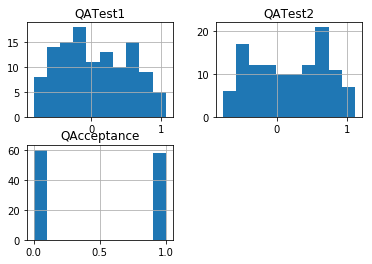

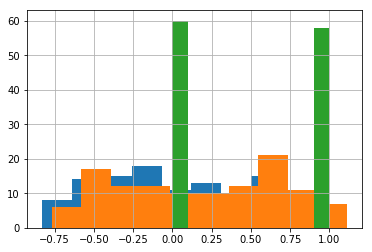

In [34]:
# Visualização da Distribuição dos Dados conforme Histograma

df.hist()
plt.pyplot.show()

df.QATest1.hist(), df.QATest2.hist(), df.QAcceptance.hist()
plt.pyplot.show()

In [35]:
df.describe()

,QATest1,QATest2,QAcceptance
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


In [36]:
df.QATest1.describe().round(2)

count    118.00
mean       0.05
std        0.50
min       -0.83
25%       -0.37
50%       -0.01
75%        0.48
max        1.07
Name: QATest1, dtype: float64

In [37]:
df.QATest2.describe().round(2)

count    118.00
mean       0.18
std        0.52
min       -0.77
25%       -0.25
50%        0.21
75%        0.65
max        1.11
Name: QATest2, dtype: float64

In [38]:
df.QAcceptance.describe().round(2)

count    118.00
mean       0.49
std        0.50
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00
Name: QAcceptance, dtype: float64

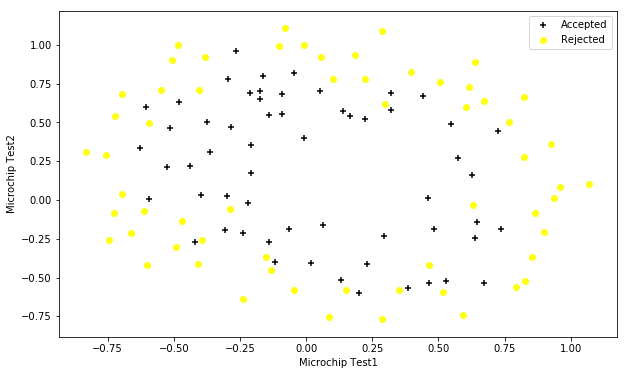

In [39]:
# Gráfico de correlação entre População e Lucro
positive = df[df['QAcceptance'].isin([1])]  
negative = df[df['QAcceptance'].isin([0])]

figura, grafico = plt.pyplot.subplots(figsize=(10,6))  
grafico.scatter(positive['QATest1'], positive['QATest2'], c='xkcd:black', marker='+', label='Accepted')  
grafico.scatter(negative['QATest1'], negative['QATest2'], c='xkcd:yellow', marker='o', label='Rejected')  
grafico.legend()  
grafico.set_xlabel('Microchip Test1')  
grafico.set_ylabel('Microchip Test2');

## 1.2 Mapeamento de características (_feature mapping_)

Uma maneira de tornar os dados mais apropriados para a classificação é criar
mais características a partir das já existentes. Para isso, você deve criar uma
função **`mapFeature`**. Essa função deve ser implementada em um arquivo de
nome **_`mapFeature.py`_**, que irá mapear as características para todos os termos
polinomiais de x1 e x2, até a sexta potência. Como resultado desse mapeamento, nosso 
vetor de duas características (os escores nos dois testes de QA) será transformado 
em um **vetor de _28 dimensões_**.

Um classificador que usa regressão logística treinado nesse vetor de características 
de maior dimensão terá uma fronteira de decisão mais complexa e parecerá não-linear 
quando desenhado em um gráfico bidimensional. 

Embora o mapeamento de características nos permita construir um classificador mais expressivo, 
também é mais suscetível a sobreajuste (overfitting). Desse modo, será implementada a 
**_Regressão Logística Regularizada_** sobre os dados fornecidos e também verá como a regularização pode 
ajudar a combater o problema do sobreajuste.

In [50]:
dF = df

In [51]:
def mapFeature(X) :
    '''
    Função de mapeamento das características
    '''
    potencia = 6
    Xf = X
    
    X1 = Xf['QATest1']  
    X2 = Xf['QATest2']

    Xf.insert(3, 'Ones', 1)

    for i in range(potencia+1):  
        for j in range(i):
            Xf['F' + str(i) + str(j)] = np.power(X1, i-j) * np.power(X2, j)

    #Xf.drop('QATest1', axis=1, inplace=True)  
    #Xf.drop('QATest2', axis=1, inplace=True)

    return Xf

In [52]:
dfeature = mapFeature(dF)
dfeature.describe()

,QATest1,QATest2,QAcceptance,Ones,F10,F20,F21,F30,F31,F32,...,F51,F52,F53,F54,F60,F61,F62,F63,F64,F65
count,118.000000,118.000000,118.000000,118.0,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,...,118.000000,1.180000e+02,118.000000,1.180000e+02,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000
mean,0.054779,0.183102,0.491525,1.0,0.054779,0.247575,-0.025472,5.983333e-02,0.030682,0.015483,...,0.011812,9.432094e-03,0.018278,4.089084e-03,7.837118e-02,-0.000703,1.893340e-02,-0.001705,2.259170e-02,-0.006302
std,0.496654,0.519743,0.502060,0.0,0.496654,0.248532,0.224075,2.746459e-01,0.134706,0.150143,...,0.072274,5.455787e-02,0.058513,9.993907e-02,1.938621e-01,0.058271,3.430092e-02,0.037443,4.346935e-02,0.090621
min,-0.830070,-0.769740,0.000000,1.0,-0.830070,0.000040,-0.484096,-5.719317e-01,-0.358121,-0.483743,...,-0.246068,-1.592528e-01,-0.142660,-4.830370e-01,6.472253e-14,-0.203971,2.577297e-10,-0.113448,2.418097e-10,-0.482684
25%,-0.372120,-0.254385,0.000000,1.0,-0.372120,0.043243,-0.178209,-5.155632e-02,-0.023672,-0.042980,...,-0.001926,-3.659760e-03,-0.001400,-7.449462e-03,8.086369e-05,-0.006381,1.258285e-04,-0.005749,3.528590e-04,-0.016662
50%,-0.006336,0.213455,0.000000,1.0,-0.006336,0.165397,-0.016521,-2.544062e-07,0.006603,-0.000039,...,0.000205,-1.473547e-07,0.001026,-8.972096e-09,4.527344e-03,-0.000004,3.387050e-03,-0.000005,3.921378e-03,-0.000020
75%,0.478970,0.646562,1.000000,1.0,0.478970,0.389925,0.100795,1.099616e-01,0.086392,0.079510,...,0.019183,1.370560e-02,0.021148,2.751341e-02,5.932959e-02,0.002104,2.090875e-02,0.001024,2.103622e-02,0.001289
max,1.070900,1.108900,1.000000,1.0,1.070900,1.146827,0.568307,1.228137e+00,0.449251,0.505577,...,0.304409,2.451845e-01,0.287323,4.012965e-01,1.508320e+00,0.250577,2.018260e-01,0.183548,2.556084e-01,0.436209


## 1.3 Função de custo e gradiente

Agora, você deverá implementar o código para calcular **_a função de custo e
o gradiente para a regressão logística regularizada_**. Crie um arquivo de nome
costFunctionReg.py que contém uma função de nome costFunctionReg.py
e que computa o custo e o gradiente. Lembre-se de que a função de custo
regularizada na regressão logística é dada por:
    
$$J_{regularizado} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(x^{(i)}\right) + (1-y^{(i)})\log\left(1- x^{(i)}\right) \large{)} }_\text{Função de Custo} + \underbrace{\frac{\lambda}{2m} \sum\limits_{j = 1}^{n}\ {\theta}_{j}^{2} }_\text{Fator Regularização} $$
    
Depois de concluir a implementação da função **costFunctionReg**, você deve
testar a corretude dela usando o valor inicial de ${\theta}$ (inicializado todo com zeros).
Você deve ver que o custo é de cerca de `0.693`.
Porém, usando a função **costFunctionReg**, você agora deve computar os valores ótimos para ${\theta}$.

In [ ]:
def sigmoid(x):
    '''
    A função sigmoid
    '''
    g = np.array([x]).flatten()
    s = 1 / (1 + np.exp(-g))
    return s

In [ ]:
def costFunctionReg(theta, X, y, alpha): 
    '''
    A versão do GD que acabamos de estudar é denominada *Batch gradienteient Descent*.
    Em cada iteração do algoritmo, todo o conjunto de treinamento é utilizado.

        X = características (features)
        y = alvo (target)
        alpha = taxa de aprendizado
        regularizacao = Taxa de regularizacaoularização

    '''
    
    m = y.size
    H = sigmoid(X.dot(theta).T)
    
    J = (1/m) * np.sum( np.multiply(-y, np.log(H)) - np.multiply((1 - y), np.log(1 - H)) )
    regularizacao = (alpha/2*m) * theta**2
    
    J_regular = J + regularizacao

    parameters = theta.shape[1]
    gradiente = np.zeros(parameters)
    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        if (i == 0):
            gradiente[i] = np.sum(term)/m
        else:
            gradiente[i] = np.sum(term)/m + ((alpha/m) * theta[:,i])

    return J, gradiente

### 1.3.1 Testando a Função de Custo e o Gradiente

In [ ]:
# set X and y (remember from above that we moved the label to column 0)
#df.QATest1
#df.QATest2

cols = df.shape[1]  
X2 = df.iloc[:,2]  
y2 = df.iloc[:,:2]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)  
y2 = np.array(y2.values)  
theta2 = np.zeros(11)

learningRate = 0.01

costFunctionReg(theta2, X2, y2, learningRate) 

## 1.4 Esboço da fronteira de decisão

Nessa parte, você deve esboçar (plotar) a fronteira de decisão que foi aprendida
para separar os exemplos positivos dos negativos. Crie uma arquivo de nome
**``plotDecisionBoundary.py``**, para criar esse gráfico que traça o limite da decisão
não-linear. Seu gráfico deve ser semelhante ao apresentado na **_Figura_** abaixo.

![ScatterBoundaryPlot](scatter_boundary.jpg)

In [53]:


#Plot Boundary
u = linspace(-1, 1.5, 50)
v = linspace(-1, 1.5, 50)
z = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = (mapFeature(array(u[i]), array(v[j])).dot(array(theta)))

z = z.T
contour(u, v, z)
title('lambda = %f' % l)
xlabel('Microchip Test 1')
ylabel('Microchip Test 2')
legend(['y = 1', 'y = 0', 'Decision boundary'])
show()




#def plotDecisionBoundary(X, y, theta, alpha, iteracao):
#    '''
#    A versão do GD que acabamos de estudar é denominada *Batch Gradient Descent*.
#    Em cada iteração do algoritmo, todo o conjunto de treinamento é utilizado.
#
#        X = características (features)
#        y = alvo (target)
#    '''
#    
#    u = linspace(-1, 1.5, 50)
#    v = linspace(-1, 1.5, 50)
#    z = zeros(shape=(len(u), len(v)))
#    for i in range(len(u)):
#        for j in range(len(v)):
#            z[i, j] = (map_feature(array(u[i]), array(v[j])).dot(array(theta)))
#
#    z = z.T
#    contour(u, v, z)
#    title('lambda = %f' % l)
#    xlabel('Microchip Test 1')
#    ylabel('Microchip Test 2')
#    legend(['y = 1', 'y = 0', 'Decision boundary'])
#    show()

TypeError: mapFeature() takes 1 positional argument but 2 were given

# 2 Regressão Linear com Regularização

Na primeira metade desta parte, você implementará a regressão linear com regularização para prever a quantidade de água fluindo de uma barragem usando a mudança do nível da água em um reservatório. Na próxima metade, você realizará diagnósticos dos algoritmos de aprendizado por meio de depuração e irá examinar os efeitos de viés (_bias_) e da variância (_variance_).

Você irá usar o dataset fornecido no arquivo **ex5data1.mat$^1$**. Nesse arquivo há registros históricos na mudança no nível da água, _x_, e da quantidade de água que sai da barragem, _y_. Este conjunto de dados é dividido em três partes:
 - Um conjunto de treinamento que seu modelo aprenderá em: _**X**_, _**y**_
 - Um conjunto de validação cruzada para determinar o parâmetro de regularizacão: _**Xval**_, _**yval**_
 - Um conjunto de testes para avaliar o desempenho. Estes são exemplos que seu modelo não irá usar durante o treino: _**Xtest**_, _**ytest**_

Os nomes das variáveis contidas no arquivo **ex5data1.mat** são os seguintes: _X_, _Xtest_, _Xval_, _y_, _ytest_, _yval_. Você irá precisar desses nomes para carregar os dados do arquivo para usar em seus scripts em Python.

_____________________________________
$^1$ Arquivos com a extensão **_.mat_** são normalmente criados no **Octave** ou no **Matlab**. Para
carregar esse arquivo no Python, você pode usar o procedimento descrito em <http://www.
blogforbrains.com/blog/2014/9/6/loading-matlab-mat-data-in-python>

In [4]:
# Carregando o arquivo gerado pelo MATLAB

import scipy.io
dfile = scipy.io.loadmat('am-T2-dados/ex5data1.mat')

## 2.1 Visualização dos Dados

Você deve começar por produzir uma visualização do conjunto de dados de treinamento. O gráfico que você deve produzir deve ser similar ao apresentado na Figura abaixo:

![scatter_trainning.jpg](scatter_trainning.jpg)


### 2.2 Função de Custo de Regressão Linear Regularizada

Lembre-se de que a regressão linear regularizada tem a seguinte função de custo:

$$J_{regularizado} = \small {\frac{1}{2m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(x^{(i)}\right) + (1-y^{(i)})\log\left(1- x^{(2)}\right) \large{)} } + {\frac{\lambda}{2m} \sum\limits_{j = 1}^{n}\ {\theta}_{j}^{2} } $$

Lembre-se de quê um hyperparâmetro que controla o grau de regularização (e assim, ajuda a prevenir o excesso de sobreajuste). O termo de regularização impõe uma penalidade sobre o custo total J**${\theta}$**. Conforme as magnitudes dos parâmetros do modelo J aumentam, a penalização aumenta também. Note que você não deve regularizar o termo **${\theta}$**.

Sua tarefa é escrever uma função para calcular a função de custo da regressão linear regularizada. Você deve implementar esse código em um arquivo de nome ${linearRegCostFunction.py}$. Se possível, tente vetorizar seu código e evitar o uso de _loops_. Quando você tiver completado a implementação, verifique a corretude da sua função de custo usando ${\theta}$ inicializado com (1, 1). Você deve esperar ver uma saída de _303.993_.

## 2.3 Gradiente na regressão linear regularizada

A derivada parcial do gradiente da função de custo da regressão linear regularizada é um vetor no qual o *j-ésimo* elemento é definido conforme a seguir:


No arquivo $linearRegCostFunction.py$, adicione código para calcular o gradiente, Quando você tiver completado essa implementação, teste a corretude usando $theta$ inicializado em (1, 1). Você deve esperar ver um gradiente de (-15.30, 598.250).

## 2.4 Ajustando os parâmetros da regressão linear

Nesta parte, use a função **linearRegCostFunction** para computar os valores ótimos para $\theta$, mas sem usar regularização, i.e., defina $\lambda$ = 0. Após isso, construa um gráfico para visualiar o modelo construído. Seu gráfico deve ser similar ao apresentado na Figura 4.

# 3 Viés-Variância

Um conceito importante no Aprendizado de Máquina é o relacionamento entre o **viés (bias) e a variância (variance)** de um modelo de aprendizado. Modelos com viés elevado não são suficientemente complexos para os dados e tendem a sofrer de subajuste (underfitting), enquanto que modelos com alta variância tendem a sofrer de sobreajuste.

Nesta parte do trabalho, você irá produzir gráficos dos erros de treinamento e teste na forma de curvas de aprendizado para diagnosticar problemas de **_viés-variância_**.

## 3.1 Curvas de Aprendizado

Agora voc^e implementara codigo para gerar as curvas de aprendizado que ser~ao uteis na depurac~ao de algoritmos de aprendizagem. Lembre-se de que uma curva de aprendizagem traca erros de treinamento e de validac~ao cruzada
como func~oes do tamanho do conjunto de treinamento. Crie um arquivo
de nome learningCurve.py que deve conter uma func~ao (tambem chamada
learningCurve) que retorna um vetor de erros para o conjunto de treinamento
e conjunto de validac~ao cruzada.

Para tracar a curva de aprendizado, precisamos de um conjunto de treinamento
e validac~ao cruzada erro para diferentes tamanhos de conjuntos de
treinamento. Para obter diferentes tamanhos de conjuntos de treinamento,
voc^e deve usar subconjuntos diferentes do conjunto de treinamento original X.
Especicamente, para um tamanho de conjunto de treinamento de i, voc^e deve
usar os primeiros exemplos de i (ou seja, X(1 : i; :) e y(1 : i)).

Para cada tamanho de conjunto de treinamento, voc^e encontrar os par^ametros
. Note que o lambda deve ser passado como um par^ametro para a func~ao
learningCurve. Depois de aprender os par^ametros , voc^e deve calcular o
erro nos conjuntos de treinamento e de validac~ao. Lembre-se de que o erro de
treinamento para um conjunto de dados e denido como:

Em particular, note que o erro de treinamento n~ao inclui o termo de regulariza
c~ao. Uma maneira de calcular o erro de treinamento e usar a sua func~ao
de custo ja implementada e denir  = 0 apenas para calcular o erro de treinamento
e o erro de validac~ao cruzada. Quando voc^e estiver computando o
erro no conjunto de treinamento, certique-se de computa-lo no subconjunto
de treinamento (ou seja, X(1 : n; :) e y(1 : n)), em vez de usar todo o conjunto
de treinamento). No entanto, para o erro de validac~ao cruzada, voc^e deve calcul
a-lo usando todo o conjunto de validac~ao cruzada. Voc^e deve armazenar os erros calculados em dois vetores.
Quando voc^e estiver terminado o que foi descrito acima, imprima as curvas
de aprendizado e produza um graco similar ao apresentado na Figura 5.

![plot_linear.jpg](plot_linear.jpg)

Na curva que voc^e ira produzir, voc^e podera observar que os erros de treinamento
e de validac~ao cruzada s~ao ambos altos quando o numero de exemplos
de treinamento e aumentado. Isso re
ete o vies alto do modelo (o modelo de
regress~ao linear e muito simples e n~ao consegue se ajustear bem ao conjunto
de dados). Na proxima sec~ao, voc^e ira implementar regress~ao polinomial para
ajustar um modelo melhor a este conjunto de dados.


# 4 Regressão Polinomial

O problema com nosso modelo linear e que ele e muito simples para os dados e
resultou em subajuste (vies alto). Nesta parte, voc^e ira resolver esse problema
adicionando mais caractersticas. Para usar a regress~ao polinomial, dena uma
hipotese da seguinte forma

# 5 Regressão Polinomial - aprendizado

Depois de ter completado $polyFeatures.py$, você deve treinar um modelo de regressão polinomial usando sua função de custo da regressão linear. Tenha em mente que, apesar de termos termos polinomiais no vector de características, ainda estamos resolvendo um problema de otimização de regressão linear. Os termos polinomiais simplesmente se transformaram em características que podemos usar para aplicar regressão linear. Estamos usando a mesma função de custo e gradiente que você implementou para a parte anterior deste trabalho.

Para esta parte do trabalho, você usará um polinômio de grau 8. Se executarmos o treinamento diretamente sobre os dados projetados, não iremos obter um bom resultado, porque as características não irão estar na mesma escala (por exemplo, um exemplo com x = 40 agora terá uma característica $xˆ8 = 40ˆ8 = 6.5 x 10ˆ1 2$). 

Portanto, você vai precisar aplicar a normalização de características. Portanto, antes de aprender os parâmetros $\theta$ para a regressão polinomial, você deve normalizar as características do conjunto de treinamento, e armazenar os parâmetros $\ho$ e $\sigma$. Depois de aprender os parâmetros $\theta$, você deve ver gerar dois gráficos (que devem ser similares aos das Figuras 6 e 7) gerados com a regressão polinomial com $\lambda$ = 0.

![plot_polinomial.jpg](plot_polinomial.jpg)

Da Figura 6, voc^e deve perceber que o polin^omio pode se ajustar aos pontos de dados muito bem - assim, obtendo um baixo erro de treinamento. No entanto, o polin^omio e muito complexo e ate mesmo despenca nos extremos. Isso e um indicador de que o modelo de regress~ao polinomial esta se ajustando demasiadamente aos dados de treinamento e que n~ao ira generalizar bem. 

![plot_curva_aprendizado.jpg](plot_curva_aprendizado.jpg)

Para entender melhor os problemas com o modelo n~ao regularizado ( = 0), voc^e pode ver que a curva de aprendizado (Figura 7) apresenta erro de treinamento baixo, mas erro de validac~ao alto. Ha uma lacuna entre os erros de treinamento e validac~ao cruzada, indicando um problema de vari^ancia alta.

# 6 Tarefas adicionais (OPCIONAIS)

 - Ajuste do par^ametro de regularizac~ao. Teste o aprendizado para diferentes valores de lambda, 1    100. Para  = 1, voc^e deve ver o polin^omio segue a tend^encia de dados bem (Figura 6) e uma curva de aprendizado (Figura 7) mostrando que tanto o erro de validac~ao quanto o erro de treinamento convergem para um valor relativamente baixo. Isso mostra que o modelo de regress~ao polinomial regularizado com  = 1 n~ao sofre dos problema de vies alto ou de vari^ancia alta. De fato, esse modelo alcanca um bom compromisso entre vies e vari^ancia. Para  = 100, voc^e deve ver um polin^omio (Figura 8) que n~ao segue os dados bem. Neste caso, ha muita regularizac~ao, e o modelo e incapaz de se ajustar aos dados de treinamento.

 - Dena o valor de  usando o conjunto de validac~ao. Implemente um metodo automatizado para selecionar o par^ametro . Concretamente, use um conjunto de validac~ao cruzada para avaliar qu~ao bom e cada valor de . Tente valores de  no intervalo f0; 0:001; 0:003; 0:01; 0:03; 0:1; 0:3; 1; 3; 10g. Ao realizar essa tarefa, voc^e deve encontrar um valor adequado de  en torno de 3 (veja a Figura 8).

 - Depois de selecionar o melhor valor de  usando o conjunto de validac~ao, voc^e pode ent~ao avaliar o modelo no conjunto de teste para estimar o qu~ao bem ele sera executado em dados reais n~ao vistos.
 
![plot_lambda.jpg](plot_lambda.jpg)

# 7 O que deve ser entregue

Voc^e deve preparar um unico relatorio para a apresentar sua analise e conclus~oes
sobre as diversas partes desse trabalho. O formato desse relatorio deve ser em
PDF. Alternativamente a entrega do relatorio em PDF, voc^e pode entregar um
notebook Jupyter2.

Independente de escolher entregar um relatorio em PDF ou na forma de
um notebook Jupyter, entregue tambem todos os arquivos em Python que voc^e
criou para cada parte deste trabalho. Todos os arquivos em Python deve estar
em uma unica pasta.

Crie um arquivo compactado que contem o relatorio (ou notebook Jupyter)
e os arquivos (scripts) em Python. Esse arquivo compactado deve se chamar
SEU NOME COMPLETO T1.zip. Esse arquivo compactado deve ser entregue pelo
Moodle, até a data acordada.

## APENDICE

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Let's modify your cost and observe the consequences.

**Exercise**: Implement `compute_cost_with_regularization()` which computes the cost given by formula (2). To calculate $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , use :
```python
np.sum(np.square(Wl))
```
Note that you have to do this for $W^{[1]}$, $W^{[2]}$ and $W^{[3]}$, then sum the three terms and multiply by $ \frac{1}{m} \frac{\lambda}{2} $.